# Introduction 
* This code is adapted from the example provided in the python optimal transport package:
https://pythonot.github.io/auto_examples/backends/plot_wass2_gan_torch.html#sphx-glr-auto-examples-backends-plot-wass2-gan-torch-py

## Imports

In [1]:
%matplotlib inline
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import torch
from torch import nn
import ot

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

torch.manual_seed(126)

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4080
__CUDA Device Total Memory [GB]: 16.860184576


## Data generation

In [2]:
sigma = 0.0
n_dims = 3
n_features = 1

def get_data(r, h, n_samples):
    # sample points on cylindrical shell 
    phi = torch.rand(n_samples) * 2 * np.pi
    z_side = torch.rand(n_samples) * h
    x_side = r * torch.cos(phi)
    y_side = r * torch.sin(phi)
    
    # setup output tensor 
    x = torch.cat([x_side]).unsqueeze(1)
    y = torch.cat([y_side]).unsqueeze(1)
    z = torch.cat([z_side]).unsqueeze(1)
    out = torch.cat((x, y, z), 1)

    return out

## Plot data



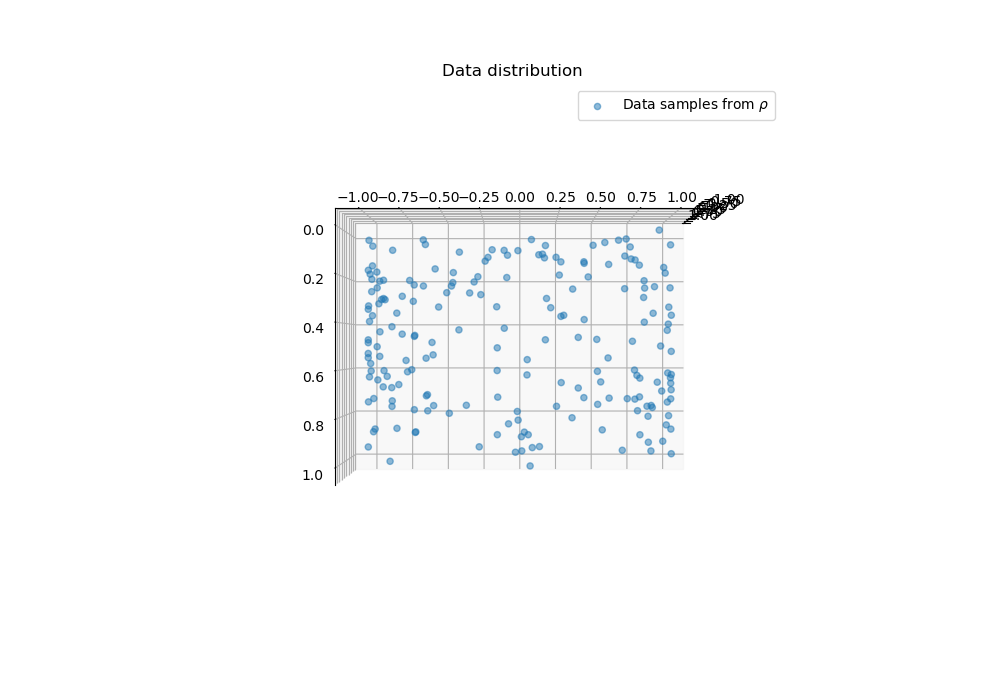

In [3]:
from mpl_toolkits import mplot3d

# plot the distributions
x =  get_data(r=1, h=1, n_samples=200)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
plt.title("simple 3D scatter plot")
ax.scatter3D(x[:, 0], x[:, 1], x[:, 2], label=r'Data samples from $\rho$', alpha=0.5)
plt.title('Data distribution')
plt.legend()

ax.view_init(-180, 0)


## Generator Model



In [4]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 1
        self.n_out = 3
        leaky = 0.001
        w_layer = 100
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, w_layer),
            nn.LeakyReLU(leaky),
            nn.Linear(w_layer, w_layer),
        )
        # add more hidden layers 
        for i in range(0,5):
            temp = nn.Sequential(
                nn.Linear(w_layer, w_layer),
                nn.LeakyReLU(leaky),
            )
            self.model.append(temp)
            
        self.model.append(nn.Linear(w_layer, self.n_out))
        
    def forward(self, x):
        x = self.model(x)
        return x


## Training the model



In [5]:
G = Generator()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)

# number of iteration and size of the batches
n_iter = 750
size_batch = 750

# generate static samples to see their trajectory along training
n_visu = 400
xnvisu = torch.rand(n_visu, n_features) # for visualization 
xvisu = torch.zeros(n_iter, n_visu, n_dims)

ab = torch.ones(size_batch) / size_batch
losses = []

# generate target data (cylindrical shell) 
xd =  get_data(r=1, h=1, n_samples=size_batch)

for i in range(n_iter):

    # generate noise samples
    xn = torch.rand(size_batch, n_features)

    # generate data samples
    # xd = get_data(size_batch)

    # generate sample along iterations
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    xg = G(xn)
    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))

    if i % 10 == 0:
        print("Iter: {:3d}, loss={}".format(i, losses[-1]))

    loss.backward()
    optimizer.step()

    del M


Iter:   0, loss=1.3496716022491455
Iter:  10, loss=1.0035549402236938
Iter:  20, loss=0.7000179886817932
Iter:  30, loss=0.5936072468757629
Iter:  40, loss=0.6211884021759033
Iter:  50, loss=0.5723997354507446
Iter:  60, loss=0.5608298778533936
Iter:  70, loss=0.5332732796669006
Iter:  80, loss=0.48180514574050903
Iter:  90, loss=0.4043545424938202
Iter: 100, loss=0.26004675030708313
Iter: 110, loss=0.23056042194366455
Iter: 120, loss=0.17175474762916565
Iter: 130, loss=0.16091491281986237
Iter: 140, loss=0.12794271111488342
Iter: 150, loss=0.14816604554653168
Iter: 160, loss=0.12813563644886017
Iter: 170, loss=0.11075086891651154
Iter: 180, loss=0.14155472815036774
Iter: 190, loss=0.14170004427433014
Iter: 200, loss=0.11890780180692673
Iter: 210, loss=0.14160235226154327
Iter: 220, loss=0.11686056852340698
Iter: 230, loss=0.09820426255464554
Iter: 240, loss=0.0942990854382515
Iter: 250, loss=0.10606295615434647
Iter: 260, loss=0.09687785804271698
Iter: 270, loss=0.09889185428619385
It

## Plot Loss

Text(0.5, 0, 'Iterations')

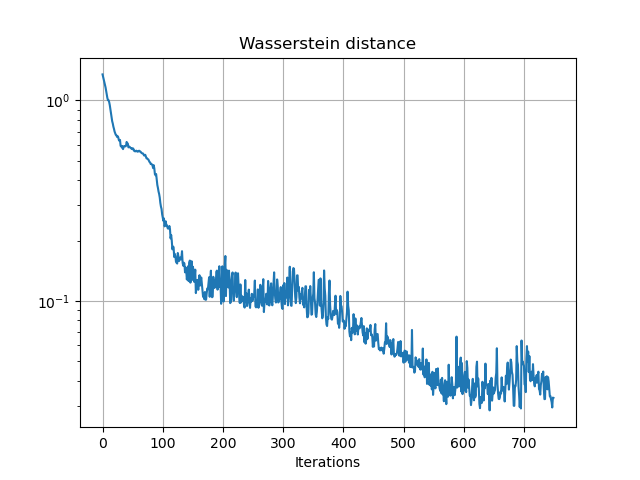

In [6]:
plt.figure()
plt.gcf().set_dpi(100) # 300 for paper
plt.semilogy(losses)
plt.grid()
plt.title('Wasserstein distance')
plt.xlabel("Iterations")

## Plot trajectories of generated samples along iterations



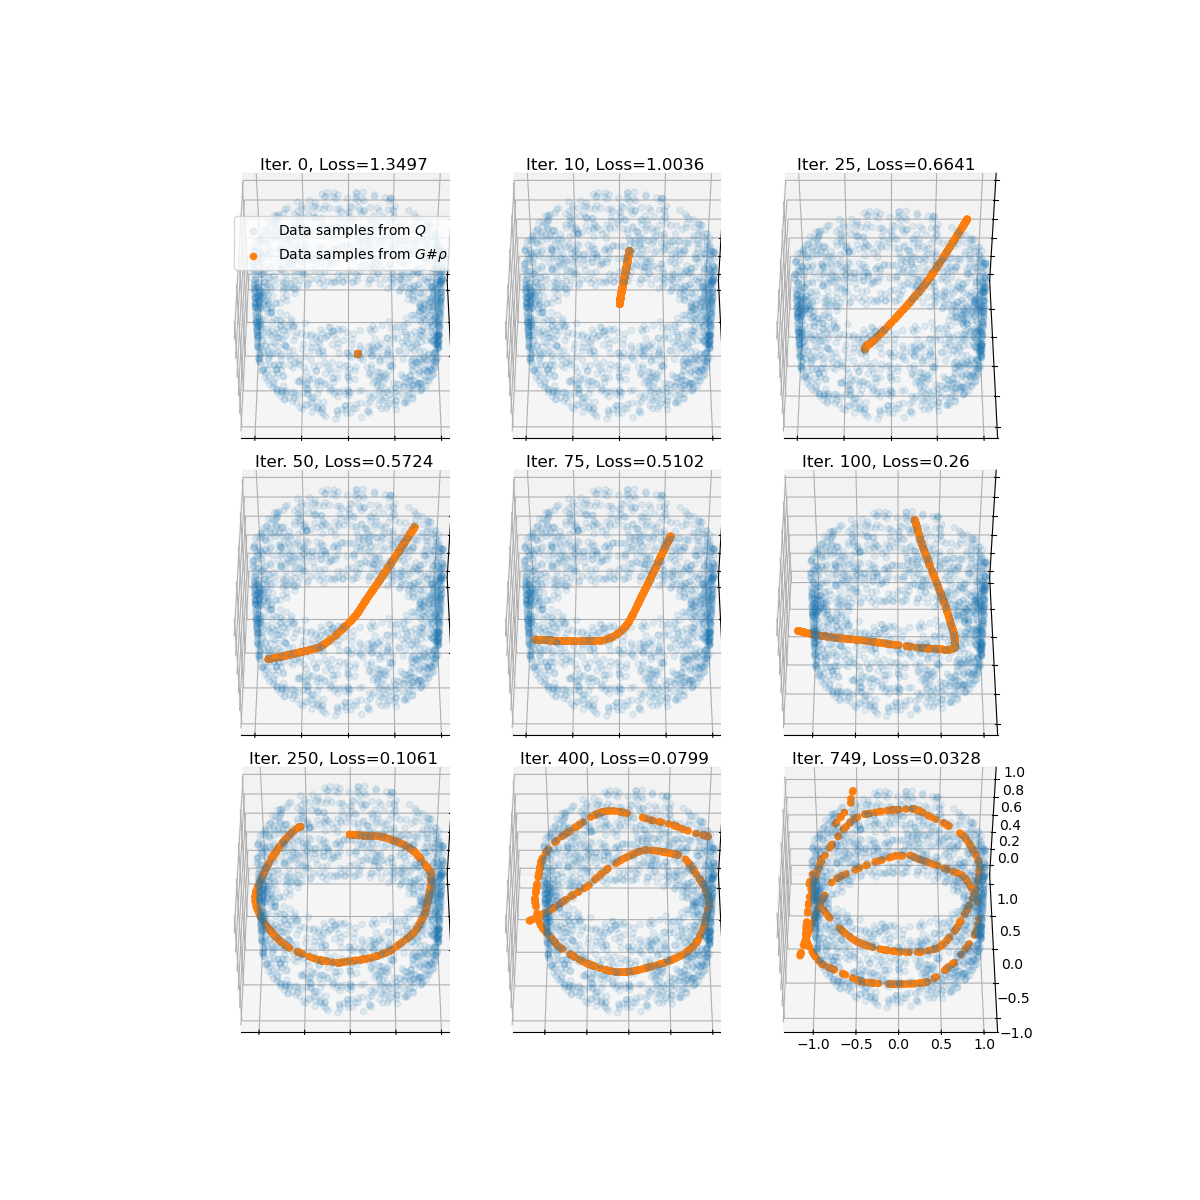

In [11]:
plt.clf()
plt.close('all')
mpl.rcParams['figure.dpi'] = 100 # 200 for paper 
ivisu = [0, 10, 25, 50, 75, 100, 250, 400, n_iter-1]


# create a figure and a 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'projection': '3d'}, edgecolor='none')

# iterate over each subplot to convert it into 3D
for i, ax in enumerate(axs.flat):

    # adjust spacing between plots
    plt.subplots_adjust(wspace=-.3, hspace=-.1)

    # plot data
    ax.scatter3D(xd[:, 0], xd[:, 1], xd[:, 2], label='Data samples from $Q$', alpha=0.1)

    # calculate distance of each point from the origin (0, 0) -> not used in paper 
    distances = xvisu[ivisu[i], :, 2]

    # use distances to map to colors
    colors = distances

    ax.scatter3D(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], xvisu[ivisu[i], :, 2],
                 label=r'Data samples from $G\#\rho$', 
                 alpha=1,
                 # c = distances, # unused color map 
                 # cmap = 'viridis'
                 )
    
    # set view 
    ax.view_init(48, -90, 0) # 44, -90, 0

    # set titles and labels, see issue https://github.com/matplotlib/matplotlib/issues/16805/
    ax.set_title(f'Iter. {ivisu[i]}, Loss={round(losses[ivisu[i]], 4)}', pad=0, y=1.000001) # need the 1.00001 to turn off auto 

    if i == 0:
        ax.legend(bbox_to_anchor=(.5, .7), loc='center', borderaxespad=0) # bbox in coordinates 
    
    # only keep labels on the final figure 
    if (i != 8): 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if (i == 8): # readjust x axis to be closer 
        ax.xaxis.set_tick_params(pad=-5)


plt.show()



## Plot trajectories - 2x3

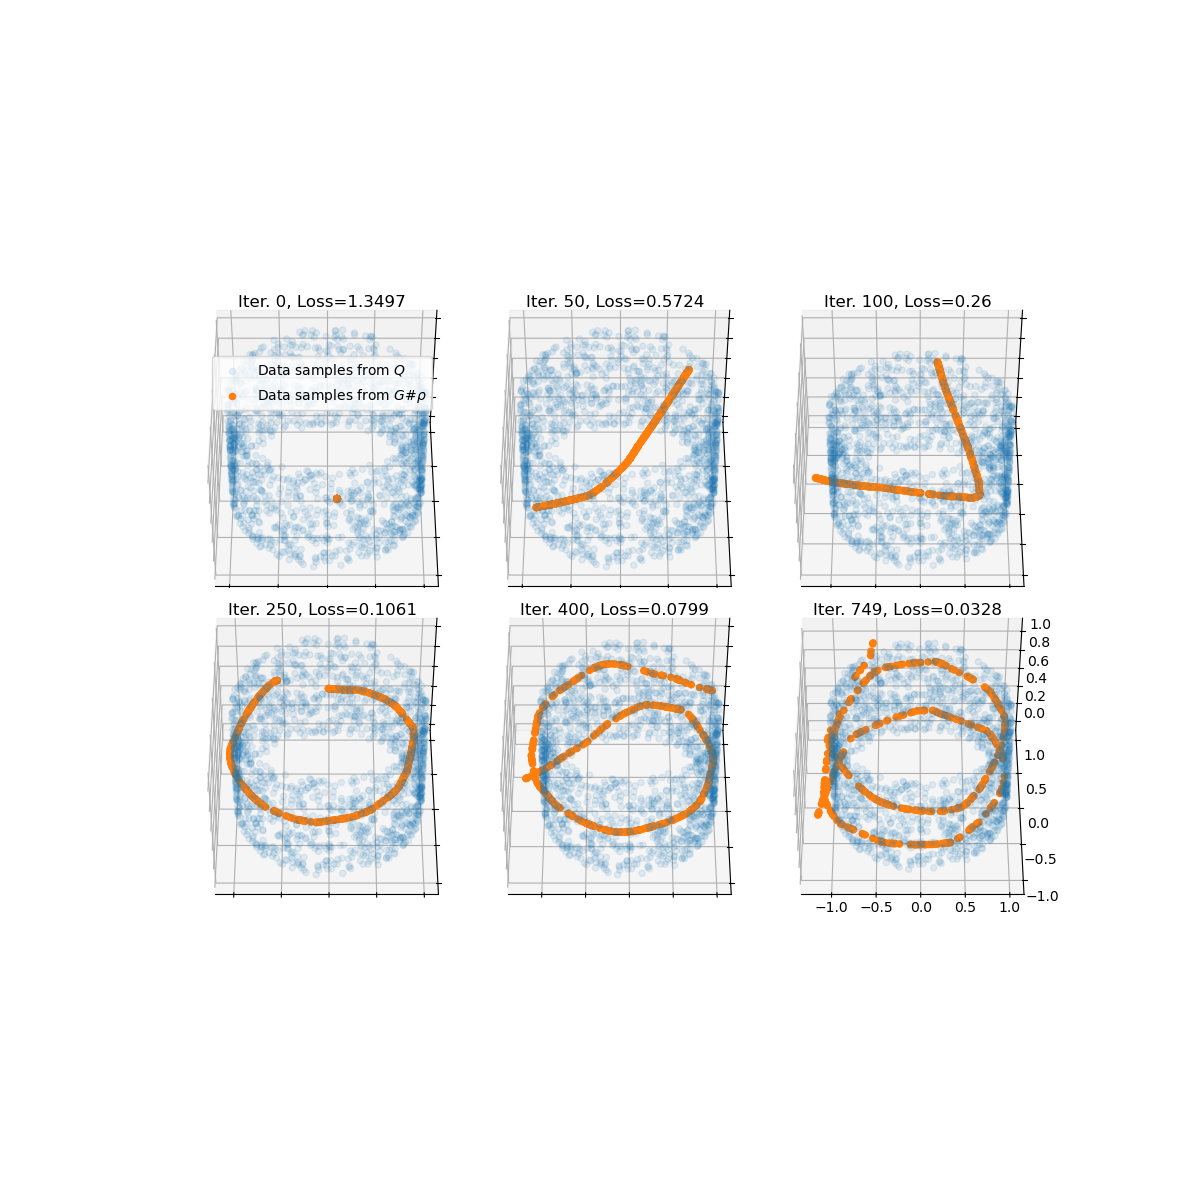

In [10]:
plt.clf()
plt.close('all')
mpl.rcParams['figure.dpi'] = 100 # 200 for paper 
ivisu = [0, 50, 100, 250, 400, n_iter-1]

# Create a figure and a 3x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(12, 12), subplot_kw={'projection': '3d'}, edgecolor='none')

# Iterate over each subplot to convert it into 3D and plot something
for i, ax in enumerate(axs.flat):

    # adjust spacing between plots
    plt.subplots_adjust(wspace=-.15, hspace=-.5)

    # plot data
    ax.scatter3D(xd[:, 0], xd[:, 1], xd[:, 2], label='Data samples from $Q$', alpha=0.1)

    # calculate the distance of each point from the origin (0, 0) -> not used in paper 
    distances = xvisu[ivisu[i], :, 2]

    # use the distances to map to colors
    colors = distances

    # plot points 
    ax.scatter3D(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], xvisu[ivisu[i], :, 2],
                 label=r'Data samples from $G\#\rho$', 
                 alpha=1,
                 # c = distances, # unused color map 
                 # cmap = 'viridis'
                 )
    
    # set view 
    ax.view_init(48, -90, 0) # 44, -90, 0

    # set titles and labels,  see issue https://github.com/matplotlib/matplotlib/issues/16805/
    ax.set_title(f'Iter. {ivisu[i]}, Loss={round(losses[ivisu[i]], 4)}', pad=0, y=1.000001) # need the 1.00001 to turn off auto 
    
    if i == 0:
        ax.legend(bbox_to_anchor=(.5, .7), loc='center', borderaxespad=0) # bbox in coordinates 
    
    # only keep labels on third figure of each row
    if (i != 5):  
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if (i == 5): # readjust x axis to be closer 
        ax.xaxis.set_tick_params(pad=-5)

plt.show()



## Generate and visualize data - For Intro

(-1.3169981628656386,
 1.1103331834077834,
 -1.1575227469205855,
 1.1027362436056136,
 -0.10149254277348518,
 1.1196563877165318)

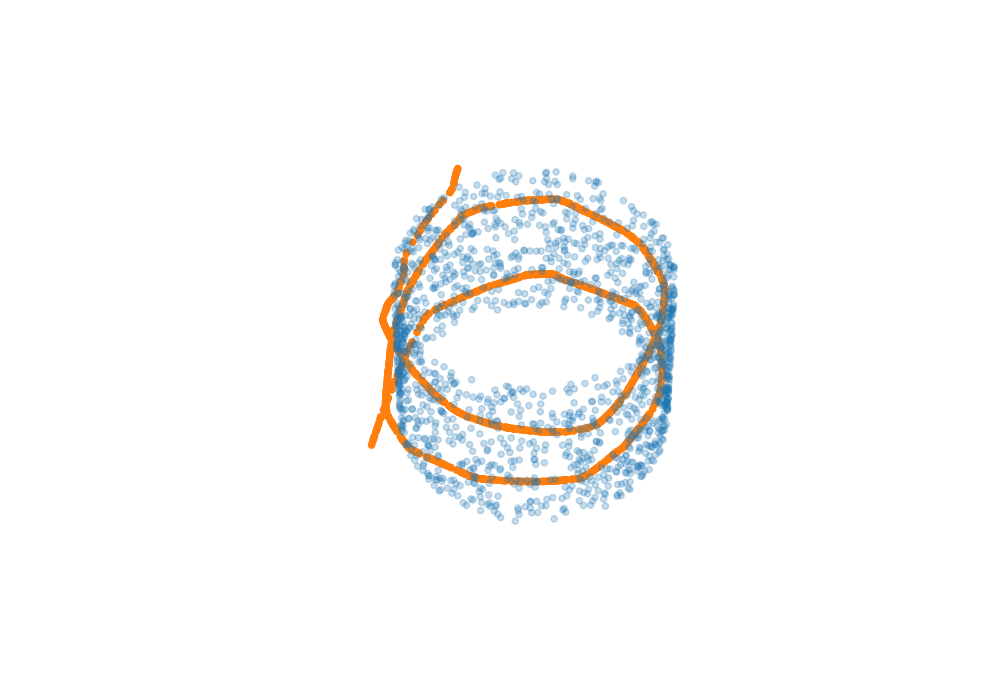

In [9]:
mpl.rcParams['figure.dpi'] = 100 # 300 for report 

size_batch = 1500 # 1500 for report 
xd =  get_data(r=1, h=1, n_samples=size_batch)
xn = torch.rand(size_batch, n_features)
x = G(xn).detach().numpy()

#########
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.view_init(48, -90, 0) # 44, -90, 0

# create plots 
ax.scatter3D(xd[:, 0], xd[:, 1], xd[:, 2], label='Data samples from $\mu_d$', alpha=0.25)
ax.scatter3D(x[:, 0], x[:, 1], x[:, 2], label='Data samples from $G\#\eta_d$', alpha=1) 

# ax.xaxis.set_tick_params(pad=-5)

# remove gridlines
ax.grid(False)
# turn off the panes background
#ax.xaxis.pane.fill = False
#ax.yaxis.pane.fill = False
#ax.zaxis.pane.fill = False
# turn off edge lines 
# ax.xaxis.pane.set_edgecolor('w')
# ax.yaxis.pane.set_edgecolor('w')
# ax.zaxis.pane.set_edgecolor('w')
ax.set_title(f'') # need the 1.00001 to turn off auto 
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
# ax.spines[['right', 'bottom']].set_visible(False)

plt.axis('off')
